In [8]:
import pandas as pd
#from hmmlearn import hmm
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
import matplotlib.pyplot as plt
#from hmmlearn.hmm import GMMHMM
from  sklearn.metrics import mean_squared_error as mse
from astropy.io import fits
import matplotlib.pyplot as plt
import os, sys

def plot_state_matrix(cm, states,title='Transition Probabilities',cmap=plt.cm.Blues):
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(states))
    plt.xticks(tick_marks, states)
    plt.yticks(tick_marks, states)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")
    plt.ylabel('Origin state')
    plt.xlabel('Destination state')
    plt.tight_layout()


dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC
folder = "/work/work_teamEXOPLANET/KOI_LC/"

time_kepler = np.load(folder+"npy/KOI_LC_time.npy") 
our_process = np.load('/work/work_teamEXOPLANET/KOI_LC/cleaned/LC_kepler_processed.npy')
our_process.shape 

(8054, 71427)

In [9]:
df= pd.read_csv(folder+"csv/kepler_dataset.csv")

df_meta=pd.read_csv('../../KOI_Data/kepler_dataset.csv')
kplr_ids=np.asarray(df['Kepler ID'].values)[[index_fp]]

In [119]:
#### importante:
def prepare_lc(fluxs): #dividir por min
    fluxs = np.asarray(fluxs)
    return fluxs/np.abs(np.nanmin(fluxs))

def det_state(a, b, n_sta):
    topes=np.linspace(a, b, n_sta+1)
    estados= []
    ind=1
    for top in topes[:-1]:
        estados.append((top,topes[ind]))
        ind+=1
    return estados

def det_state_2ways(a, b, n_sta_up, n_sta_low):
    estados_up = det_state(a, 0, n_sta_up)
    estados_low = det_state(0, b, n_sta_low)
    return estados_up + estados_low


dirpath = os.getcwd().split("code")[0]+"code/obj4"
sys.path.append(dirpath)
from fold import *

def global_fold(t, fluxs, per, t0, T=1000):
    t_fold, val_fold = phase_fold_and_sort_light_curve(t, fluxs, period= per, t0= t0)
    return global_view(t_fold, val_fold, period=per, num_bins=T, bin_width_factor=1 / T)

## Version paralela (Numba)
para instalar numba: **pip install numba**

In [11]:
from numba import njit, jit
#from numba.typed import List

In [186]:
## no python: njit -- no soporta lista de lista, lista de arrays, si soporta: lista de sets

@njit(parallel=False, cache=True, fastmath=True)
def det_celda(num, estados): 
    for celda, (est_low, est_up) in enumerate(estados):
        if num<est_low and num>=est_up:
            return celda
    if num >= estados[0][0]:
        return 0 #si se "sale" por arriba
    elif num <= estados[-1][1]:
        return len(estados)-1 #si se "sale" por abajo
    return 0

@njit(parallel=False, cache=True, fastmath=True)  #no se pudo paralelizar por el acceso a lista "ind -1"
def add_transitions(dt, fluxs, transition_m, states,states_t):
    for ind in range(1,len(fluxs)):
        init_s = det_celda(fluxs[ind-1], states)
        fin_s = det_celda(fluxs[ind], states)
        time_s = det_celda(dt[ind], states_t)
        transition_m[init_s, fin_s, time_s] += 1
    #return transition_m

@njit(parallel=True, cache=False, fastmath=True)
def manual_HMM(dt, fluxs, states, states_t):
    n_sta = len(states)
    n_sta_t = len(states_t)
    
    transition_m = np.zeros((n_sta, n_sta, n_sta_t))
    add_transitions(dt, fluxs, transition_m, states, states_t)
    
    for t in range(n_sta_t):
        for i in range(n_sta):
            suma_it = 0
            for j in range(n_sta):
                transition_m[i,j,t] +=1 #priors
                suma_it += transition_m[i,j,t]
            transition_m[i,:,t] = transition_m[i,:,t]/suma_it #normalize
    return transition_m


In [139]:
coupled_LC = []
coupled_deltaT = []
coupled_deltaT_log = []
for i in range(our_process.shape[0]):
    #borrar nans... arreglo variable
    mask_nan_aux = np.isnan(our_process[i])
    coupled_LC.append(our_process[i][~mask_nan_aux])
    time_i = time_kepler[i][~mask_nan_aux]
    coupled_deltaT.append(np.hstack([[0],np.diff(time_i)]))
    coupled_deltaT_log.append(np.log(coupled_deltaT[-1]+1))
    
coupled_LC = np.asarray(coupled_LC)
coupled_deltaT = np.asarray(coupled_deltaT)
coupled_deltaT_log = np.asarray(coupled_deltaT_log)

coupled_deltaT

array([array([0.       , 0.0204347, 0.0204346, ..., 0.0204347, 0.0204346,
       0.0204347]),
       array([0.       , 0.0408658, 0.0204329, ..., 0.0204347, 0.0204345,
       0.0204348]),
       array([0.       , 0.0204347, 0.0204345, ..., 0.0204346, 0.0204346,
       0.0204347]),
       ...,
       array([0.       , 0.0204343, 0.0204342, ..., 0.0204342, 0.020434 ,
       0.0204343]),
       array([0.       , 0.0204343, 0.0204342, ..., 0.0204342, 0.020434 ,
       0.0204343]),
       array([0.       , 0.0204342, 0.0204342, ..., 0.0204341, 0.0204341,
       0.0204343])], dtype=object)

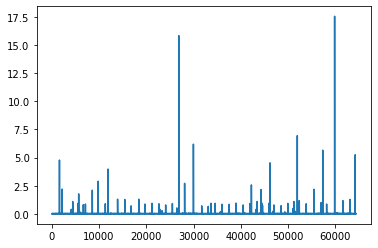

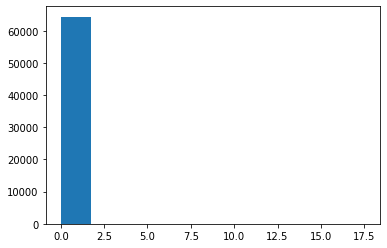

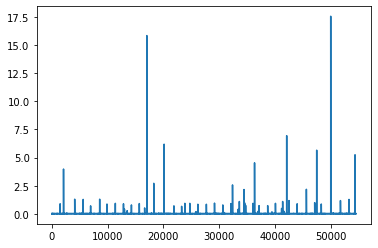

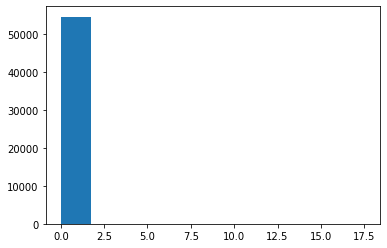

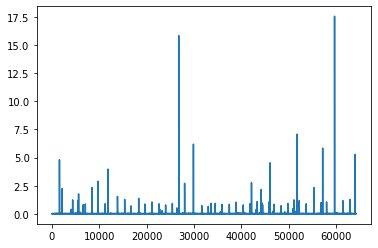

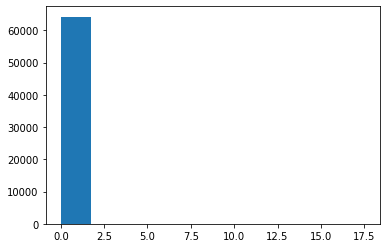

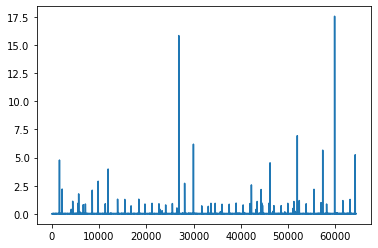

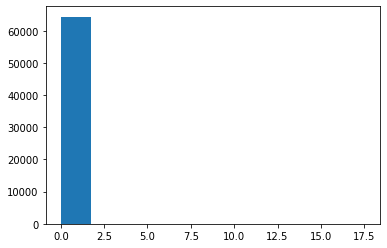

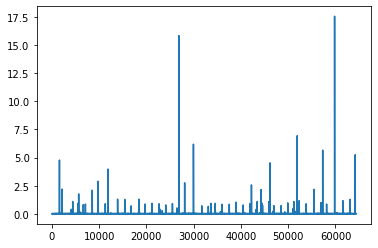

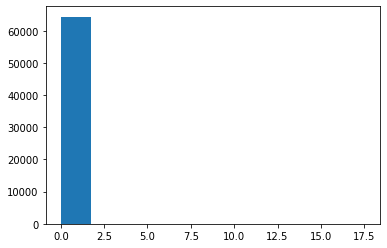

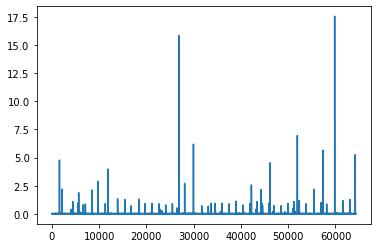

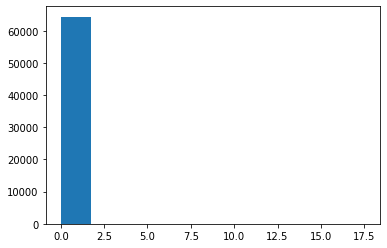

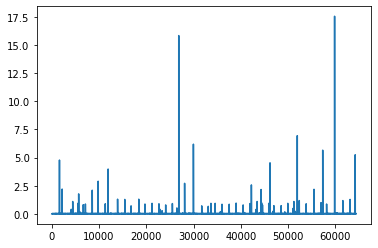

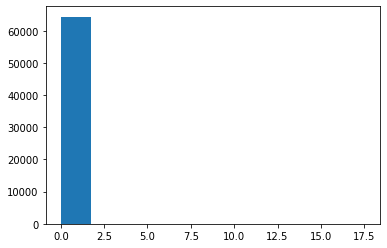

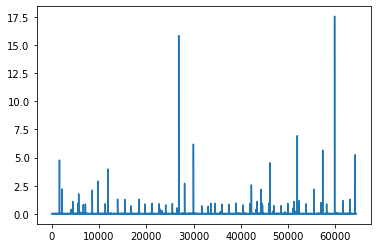

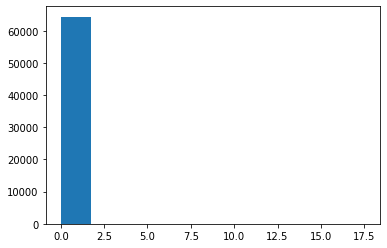

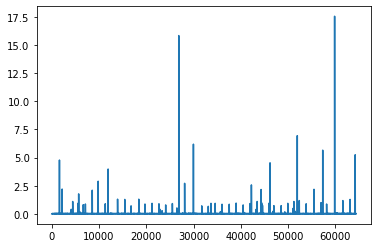

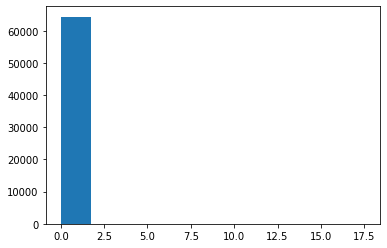

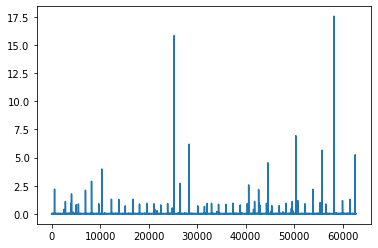

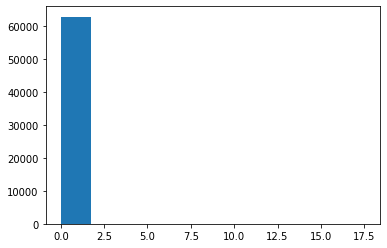

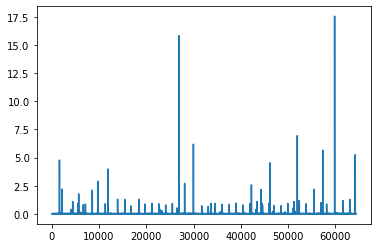

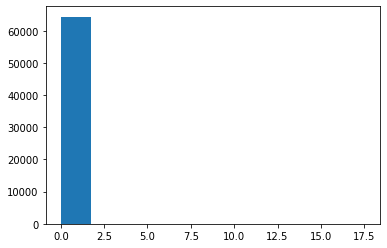

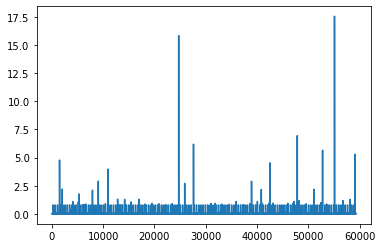

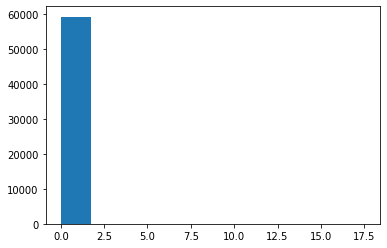

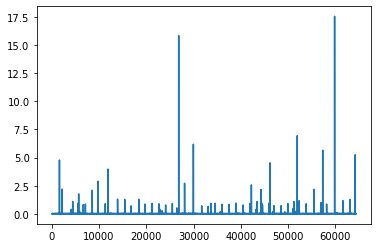

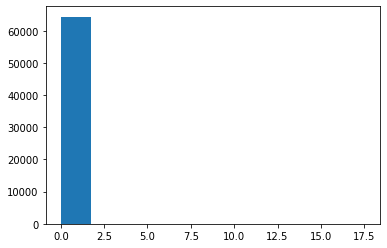

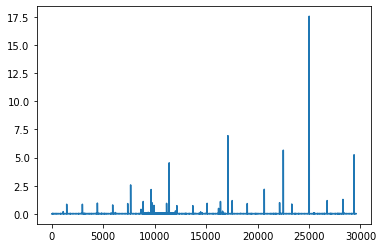

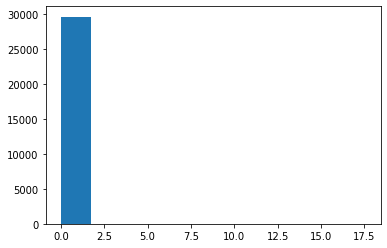

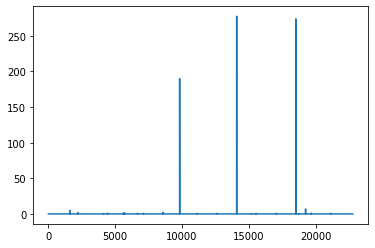

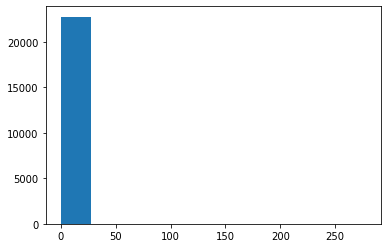

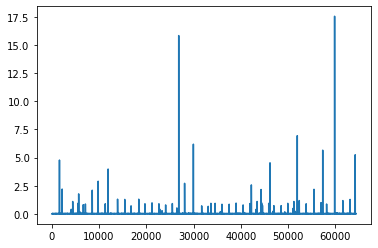

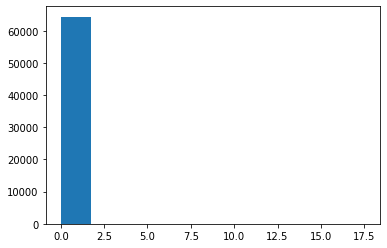

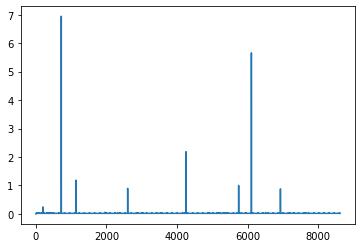

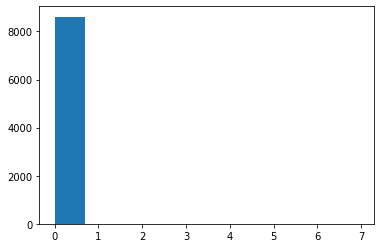

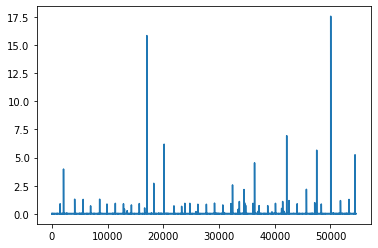

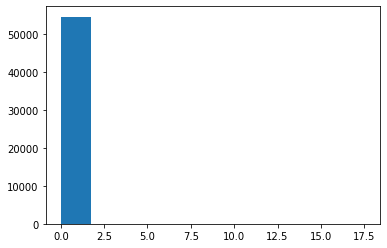

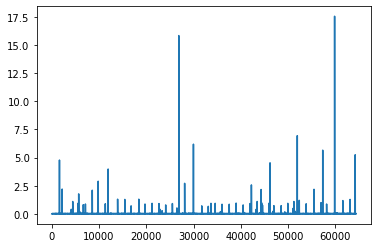

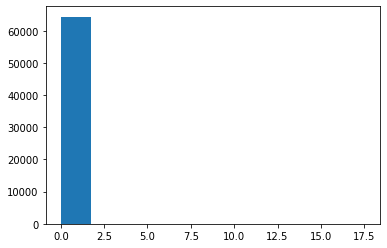

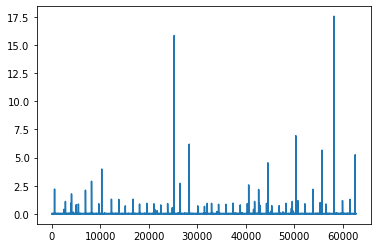

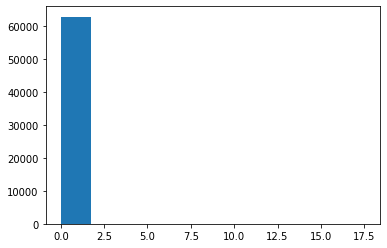

In [36]:
for i in range(20):
    plt.plot(coupled_deltaT[i])
    plt.show()
    plt.hist(coupled_deltaT[i])
    plt.show()

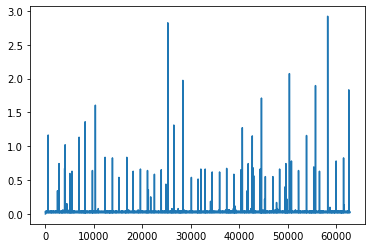

In [44]:
plt.plot(np.log(coupled_deltaT[i]+1))
plt.show()

In [240]:
m_std = []
for i in range(coupled_deltaT.shape[0]):
    m_std.append(np.std(coupled_deltaT[i]))
m_std

[0.1141529908174273,
 0.12051967666417396,
 0.1150494870661587,
 0.11414108601693647,
 0.11424093461341256,
 0.11426208910348166,
 0.11416327921187588,
 0.11415527463743781,
 0.11416428937162373,
 0.11403099117814779,
 0.11415517140306905,
 0.12476304692554732,
 0.11415054842309105,
 0.12586182780599847,
 2.8735824190988266,
 0.11417225670931905,
 0.10125121099847148,
 0.1204576319531664,
 0.11415751652591932,
 0.11406645061702603,
 0.11668242133692266,
 0.11417217001716382,
 0.11636736426665492,
 0.12127337386207479,
 0.11429486214724642,
 0.11415954837328582,
 0.11416786878685375,
 0.11416240368208172,
 0.11418053988106783,
 0.1141695194725884,
 0.12336543267567572,
 0.12050253527576688,
 1.7290600132722038,
 0.11417255122566565,
 0.11419017786398951,
 0.11404506810291698,
 0.11417709110680709,
 0.11417409303745873,
 0.11417686491718294,
 0.12422503792598391,
 0.11415139288763344,
 0.17971131059984802,
 0.11416075805723078,
 0.11416830230992565,
 0.11405660052661744,
 0.1141745325738

In [245]:
np.argsort(m_std)[::-1]

array([5912, 2341, 5796, ..., 4914, 5913, 6434])

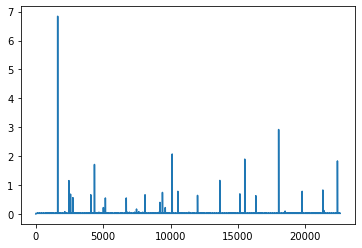

In [246]:
plt.plot(coupled_deltaT_log[2341])

In [46]:
maximos = []
for i in range(coupled_deltaT.shape[0]):
    maximos.append(np.max(coupled_deltaT[i]))
maximos

[17.551969199999803,
 17.55196920000003,
 17.5519726,
 17.55197209999983,
 17.551967200000036,
 17.55197249999992,
 17.55197350000003,
 17.55197350000003,
 17.551971500000036,
 17.55196570000021,
 17.551962999999887,
 17.551962999999887,
 17.551956899999823,
 17.55195679999997,
 277.570106,
 17.551975500000026,
 6.947599500000024,
 17.551954599999817,
 17.55195309999999,
 17.55198500000006,
 17.55198500000006,
 17.55198220000011,
 17.55198220000011,
 17.55198220000011,
 17.551977899999883,
 17.55196460000002,
 17.551959100000204,
 17.551955299999918,
 17.551948300000277,
 17.551947000000155,
 17.85844350000025,
 17.551945800000112,
 189.97576709999987,
 17.552110999999968,
 17.551983800000016,
 17.551979200000005,
 17.551964999999882,
 17.551954400000113,
 17.551951600000393,
 17.551951600000393,
 17.551942399999916,
 17.551939100000027,
 17.55211439999971,
 17.552113099999815,
 17.55211290000011,
 17.552109699999846,
 17.552109699999846,
 17.552106400000184,
 17.551991600000065,
 17.5

934.4447049999998

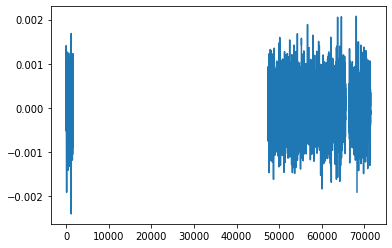

In [54]:
plt.plot(our_process[2341])
np.max(maximos)

In [85]:
np.log(np.max(maximos)+1)

6.841022036538049

In [86]:
np.log(4*365+1) #maximo posible..

7.2868764117507

In [79]:
det_state(7, 0, n_sta=10)

[(7.0, 6.3),
 (6.3, 5.6),
 (5.6, 4.8999999999999995),
 (4.8999999999999995, 4.199999999999999),
 (4.199999999999999, 3.4999999999999996),
 (3.4999999999999996, 2.8),
 (2.8, 2.0999999999999996),
 (2.0999999999999996, 1.3999999999999995),
 (1.3999999999999995, 0.6999999999999994),
 (0.6999999999999994, -6.661338147750939e-16)]

In [257]:
estados = det_state(2, 0, n_sta=5)
for l1, l2 in estados:
    print("Slice con deltas entre %f y %f"%(np.exp(l1)-1, np.exp(l2)-1))

Slice con deltas entre 6.389056 y 3.953032
Slice con deltas entre 3.953032 y 2.320117
Slice con deltas entre 2.320117 y 1.225541
Slice con deltas entre 1.225541 y 0.491825
Slice con deltas entre 0.491825 y 0.000000


In [98]:
df["Period"].min() #minimo peridoo es 0.26 

0.259819659

In [258]:
fluxs = prepare_lc(coupled_LC[2341]) #divide by min

states_values = det_state_2ways(1,-1, n_sta_up=8, n_sta_low=8) 
states_t = det_state(2, 0, n_sta=5)

transition_m = manual_HMM(coupled_deltaT_log[2341], fluxs, states_values, states_t)
transition_m

array([[[0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0625    ],
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0625    ],
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0625    ],
        ...,
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0625    ],
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0625    ],
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0625    ]],

       [[0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.04761905],
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0952381 ],
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0952381 ],
        ...,
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.04761905],
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.04761905],
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.04761905]],

       [[0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.03225806],
        [0.0625    , 0.0625    , 0.0625    , 0.0625    , 0.0

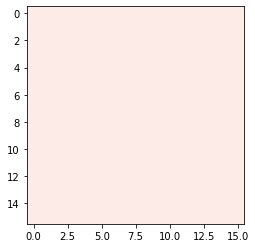

In [262]:
plt.imshow(transition_m[:,:,-4], cmap="RdPu", vmin=0, vmax=1) #casi no ocupan mas lla del 3

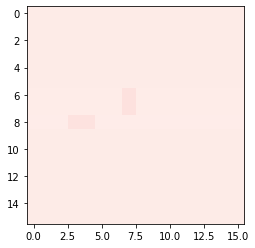

In [197]:
plt.imshow(transition_m[:,:,-3], cmap="RdPu", vmin=0, vmax=1)

### Comportamiento Falsos postiviso

In [16]:
falsos_pos=df.loc[df['NExScI Disposition']=='FALSE POSITIVE']
index_fp=list(falsos_pos.index)
len(index_fp)

our_detrends=our_process[index_fp]
our_detrends.shape

(3976, 71427)

recuperando curva 1
Cantidad de tramos:  707
Largo promedio de tramos:  77.06506364922207
Mediana de largo de tramos:  72.0
Min de largo de tramos:  2
Max de largo de tramos:  146


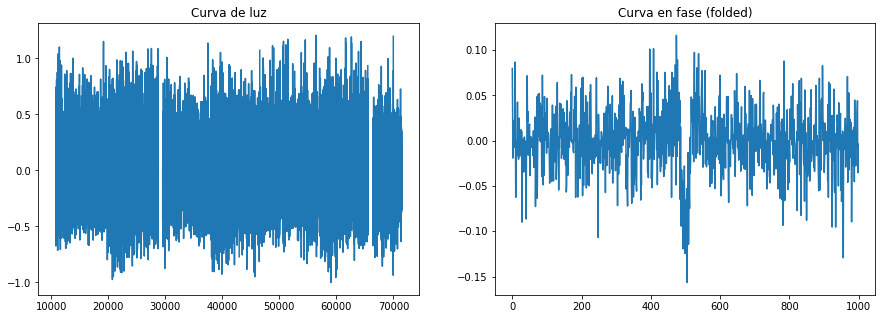

<ipython-input-12-b049d4a47ba3>:70: NumbaWarning: Cannot cache compiled function "det_state_2ways" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  states = det_state_2ways(1,-1, n_sta_up=n_sta_up, n_sta_low=n_sta_low)
/opt/ohpc/pub/moduledeps/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:1958: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'wind_fluxs' of function 'manual_HMM'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-12-b049d4a47ba3>", line 63:
@njit(parallel=True, cache=False, fastmath=True)
def manual_HMM(wind_fluxs, n_sta_up, n_sta_low=0):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


Cantidad de tramos:  708
Largo promedio de tramos:  77.03672316384181
Mediana de largo de tramos:  72.0
Min de largo de tramos:  2
Max de largo de tramos:  146


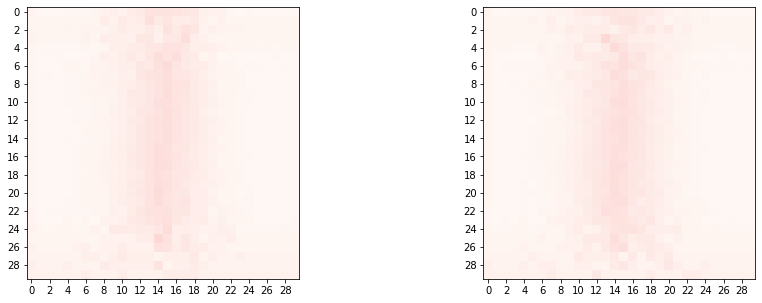

recuperando curva 2
Cantidad de tramos:  803
Largo promedio de tramos:  79.91158156911581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


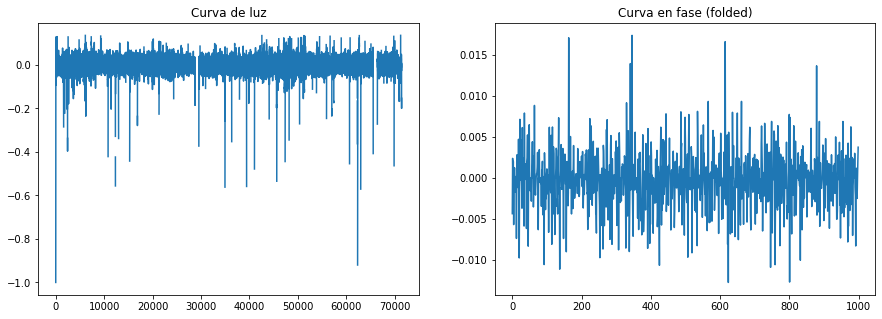

Cantidad de tramos:  804
Largo promedio de tramos:  79.88308457711443
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


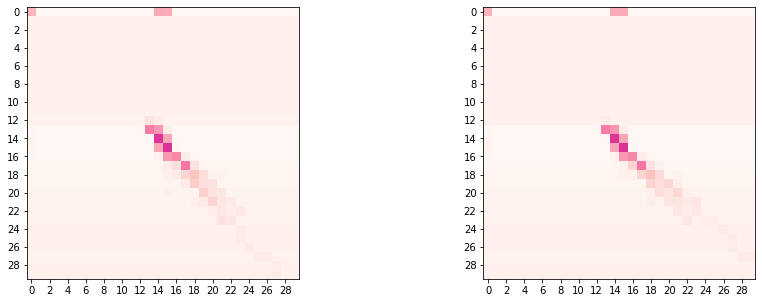

recuperando curva 3
Cantidad de tramos:  788
Largo promedio de tramos:  81.66116751269035
Mediana de largo de tramos:  84.0
Min de largo de tramos:  2
Max de largo de tramos:  146


KeyboardInterrupt: 

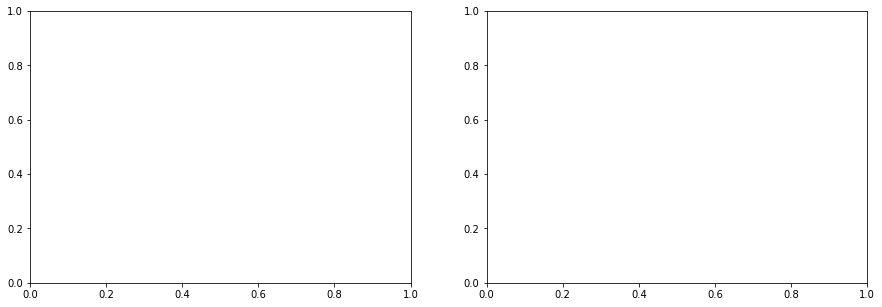

In [19]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    per, t0 = df[["Period", "Time of Transit Epoch"]].values[index_fp][i]
    mask_v = ~np.isnan(fluxs)
    f_glo = global_fold(time_kepler[index_fp][i][mask_v], fluxs[mask_v], per, t0)
    axx[0].plot(fluxs)
    axx[0].set_title("Curva de luz")
    axx[1].plot(f_glo)
    axx[1].set_title("Curva en fase (folded)")
    plt.show()
    
    transition_m = manual_HMM(lc_tramos, n_sta_up=15, n_sta_low=15) #si se dejan 5 arriba y 10 abajo cambia harto...

    i+=1
    
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[0].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_xticklabels(labels_x)
    axx[0].set_yticklabels(labels_x)
    
    #curva en reversa...
    fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
    lc_tramos =  extract_nans(fluxs) #extract nans
    transition_m = manual_HMM(lc_tramos, n_sta_up=15, n_sta_low=15) #si se dejan 5 arriba y 10 abajo cambia harto...
    
    axx[1].imshow(transition_m, cmap='RdPu', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[1].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_xticklabels(labels_x)
    axx[1].set_yticklabels(labels_x)
    
    plt.show()

### Comportamiento Confirmados

In [38]:
confirmados=df.loc[df['NExScI Disposition']=='CONFIRMED']
index_con=list(confirmados.index)
our_detrends=our_process[index_con]
len(index_con)

2281

recuperando curva 1
Cantidad de tramos:  796
Largo promedio de tramos:  80.82663316582915
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  796
Largo promedio de tramos:  80.72110552763819
Mediana de largo de tramos:  78.5
Min de largo de tramos:  2
Max de largo de tramos:  149


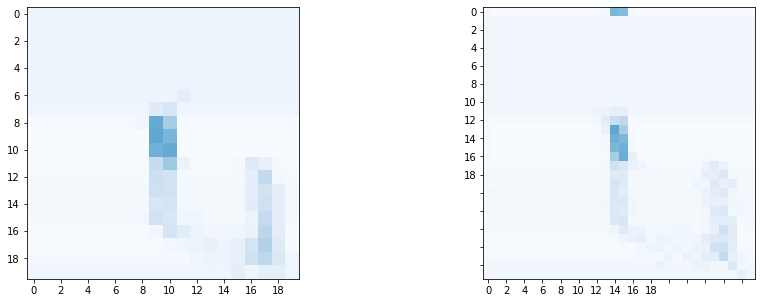

recuperando curva 2
Cantidad de tramos:  807
Largo promedio de tramos:  79.71623296158612
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  807
Largo promedio de tramos:  79.61214374225527
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


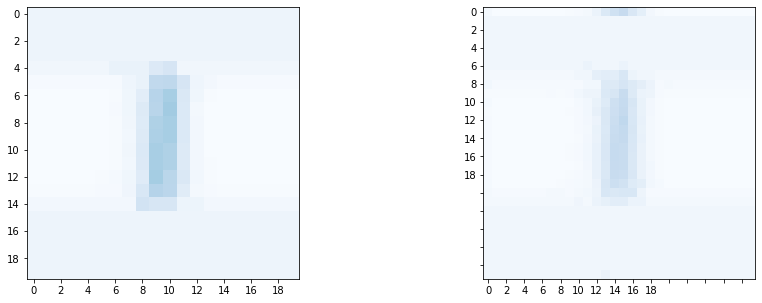

recuperando curva 3
Cantidad de tramos:  822
Largo promedio de tramos:  78.24209245742092
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146
Cantidad de tramos:  822
Largo promedio de tramos:  78.13990267639903
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  146


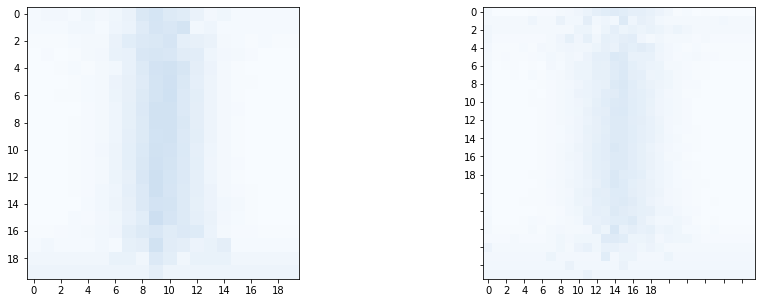

recuperando curva 4
Cantidad de tramos:  863
Largo promedio de tramos:  72.9316338354577
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146
Cantidad de tramos:  863
Largo promedio de tramos:  72.83429895712631
Mediana de largo de tramos:  66.0
Min de largo de tramos:  2
Max de largo de tramos:  146


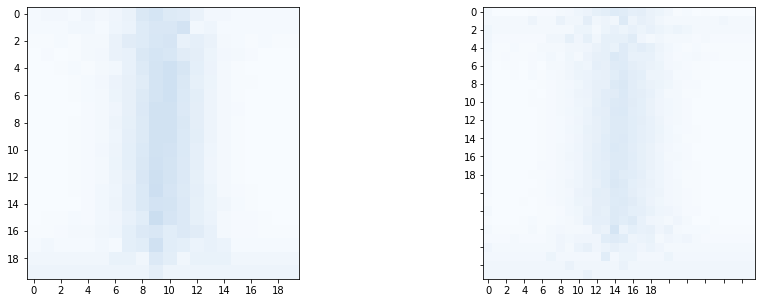

recuperando curva 5
Cantidad de tramos:  824
Largo promedio de tramos:  78.05097087378641
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  824
Largo promedio de tramos:  77.94902912621359
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149


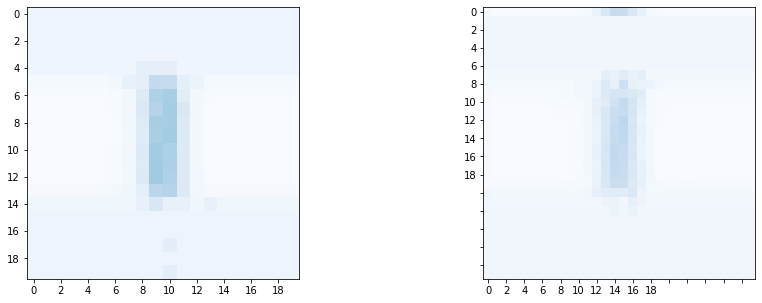

recuperando curva 6
Cantidad de tramos:  680
Largo promedio de tramos:  80.16323529411764
Mediana de largo de tramos:  79.5
Min de largo de tramos:  2
Max de largo de tramos:  146
Cantidad de tramos:  681
Largo promedio de tramos:  80.12922173274596
Mediana de largo de tramos:  79.0
Min de largo de tramos:  2
Max de largo de tramos:  146


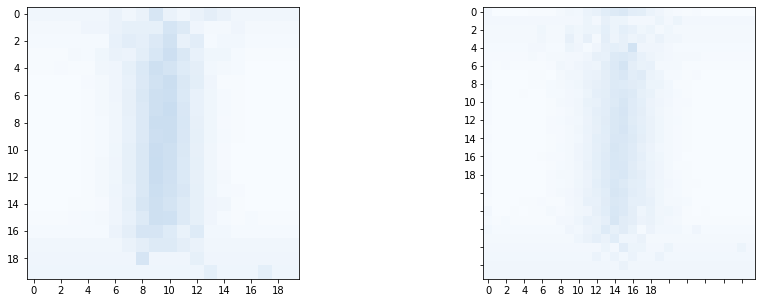

recuperando curva 7
Cantidad de tramos:  843
Largo promedio de tramos:  76.26453143534994
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  843
Largo promedio de tramos:  76.16488730723606
Mediana de largo de tramos:  71.0
Min de largo de tramos:  2
Max de largo de tramos:  149


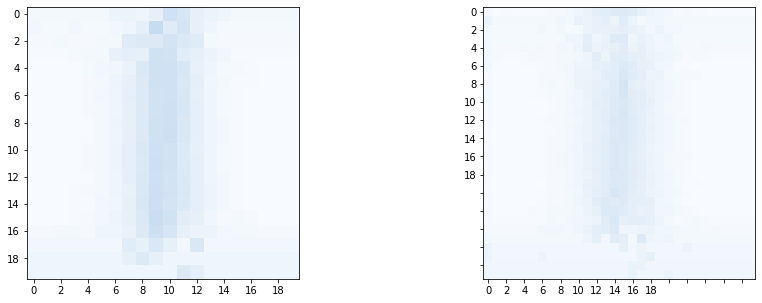

recuperando curva 8
Cantidad de tramos:  818
Largo promedio de tramos:  78.62713936430318
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  818
Largo promedio de tramos:  78.52444987775061
Mediana de largo de tramos:  77.5
Min de largo de tramos:  2
Max de largo de tramos:  149


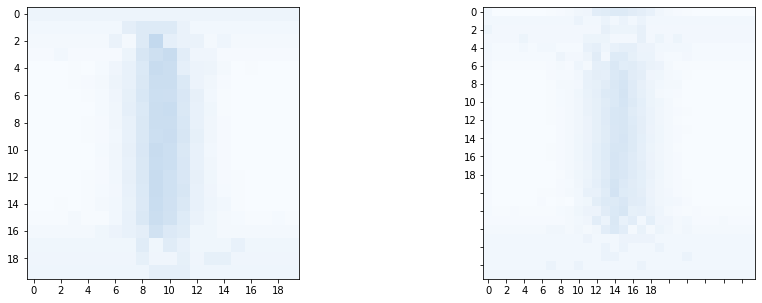

recuperando curva 9
Cantidad de tramos:  822
Largo promedio de tramos:  74.98418491484185
Mediana de largo de tramos:  69.5
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  822
Largo promedio de tramos:  74.88199513381996
Mediana de largo de tramos:  69.0
Min de largo de tramos:  2
Max de largo de tramos:  149


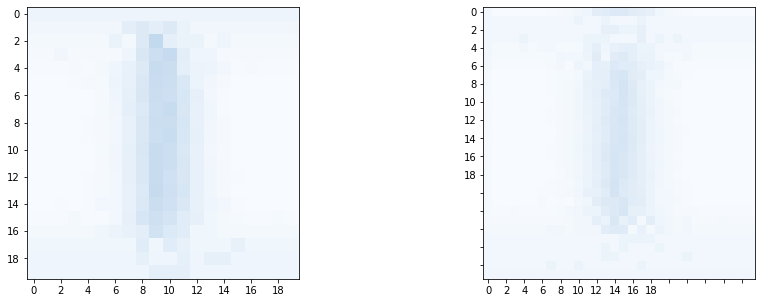

recuperando curva 10
Cantidad de tramos:  160
Largo promedio de tramos:  82.05
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145
Cantidad de tramos:  161
Largo promedio de tramos:  81.8944099378882
Mediana de largo de tramos:  88.0
Min de largo de tramos:  2
Max de largo de tramos:  145


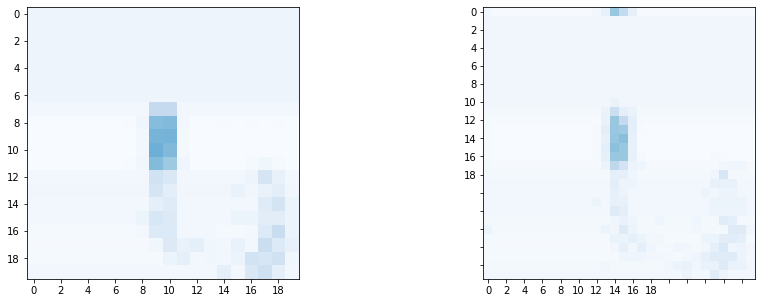

recuperando curva 11
Cantidad de tramos:  815
Largo promedio de tramos:  78.92515337423313
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  815
Largo promedio de tramos:  78.82208588957056
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


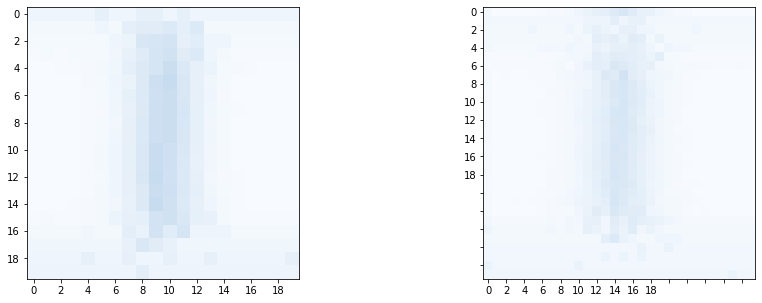

recuperando curva 12
Cantidad de tramos:  825
Largo promedio de tramos:  77.94787878787879
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  825
Largo promedio de tramos:  77.8460606060606
Mediana de largo de tramos:  76.0
Min de largo de tramos:  2
Max de largo de tramos:  149


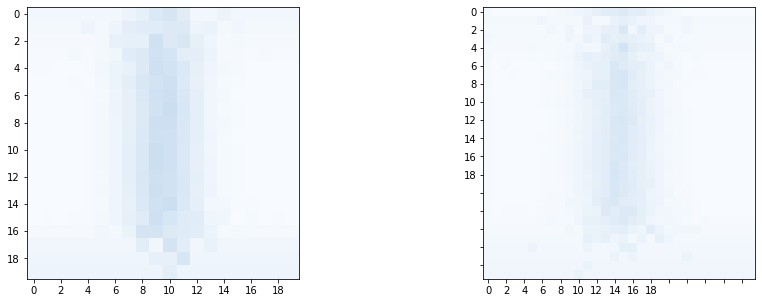

recuperando curva 13
Cantidad de tramos:  831
Largo promedio de tramos:  77.38146811070999
Mediana de largo de tramos:  74.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  831
Largo promedio de tramos:  77.28038507821901
Mediana de largo de tramos:  73.0
Min de largo de tramos:  2
Max de largo de tramos:  149


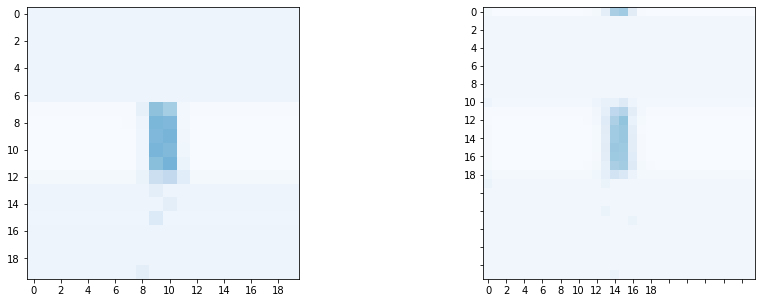

recuperando curva 14
Cantidad de tramos:  801
Largo promedio de tramos:  80.32209737827715
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  801
Largo promedio de tramos:  80.21722846441948
Mediana de largo de tramos:  80.0
Min de largo de tramos:  2
Max de largo de tramos:  149


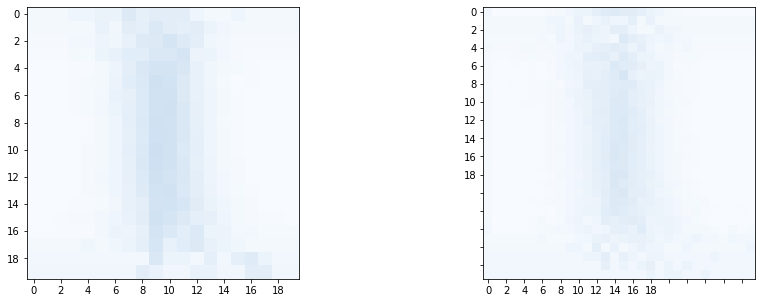

recuperando curva 15
Cantidad de tramos:  857
Largo promedio de tramos:  72.44690781796966
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  857
Largo promedio de tramos:  72.34889148191365
Mediana de largo de tramos:  62.0
Min de largo de tramos:  2
Max de largo de tramos:  149


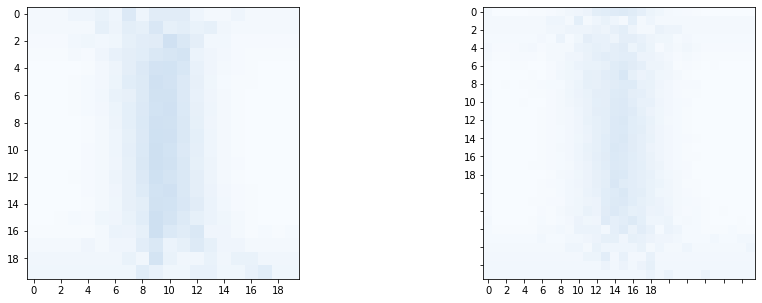

recuperando curva 16
Cantidad de tramos:  812
Largo promedio de tramos:  79.18349753694581
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  812
Largo promedio de tramos:  79.08004926108374
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149


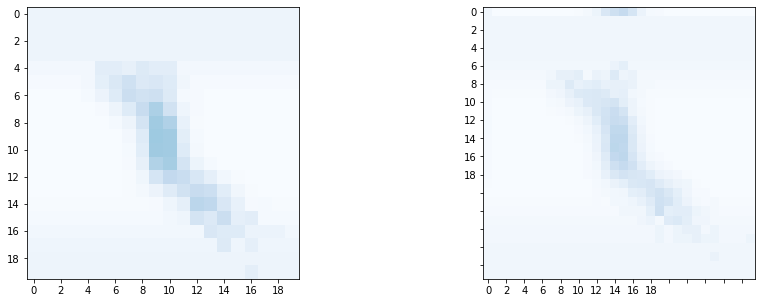

recuperando curva 17
Cantidad de tramos:  912
Largo promedio de tramos:  67.91228070175438
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146
Cantidad de tramos:  912
Largo promedio de tramos:  67.90131578947368
Mediana de largo de tramos:  58.0
Min de largo de tramos:  2
Max de largo de tramos:  146


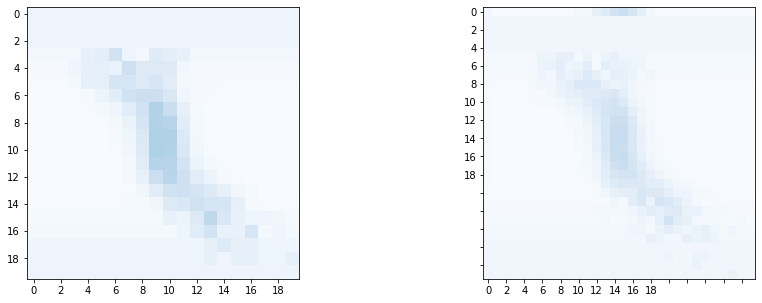

recuperando curva 18
Cantidad de tramos:  832
Largo promedio de tramos:  77.28966346153847
Mediana de largo de tramos:  75.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  832
Largo promedio de tramos:  77.18870192307692
Mediana de largo de tramos:  74.5
Min de largo de tramos:  2
Max de largo de tramos:  149


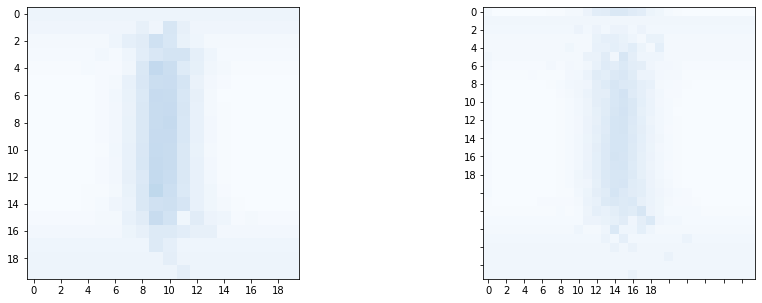

recuperando curva 19
Cantidad de tramos:  816
Largo promedio de tramos:  78.82107843137256
Mediana de largo de tramos:  78.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  816
Largo promedio de tramos:  78.71813725490196
Mediana de largo de tramos:  77.5
Min de largo de tramos:  2
Max de largo de tramos:  149


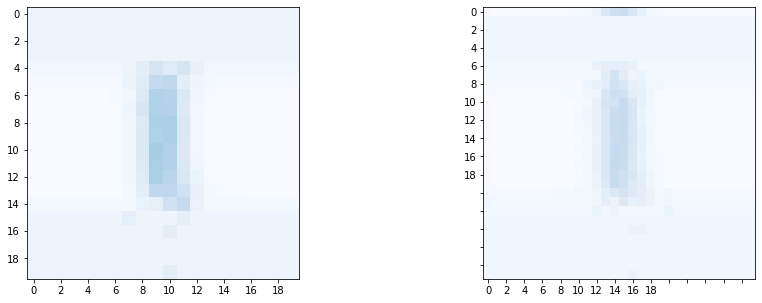

recuperando curva 20
Cantidad de tramos:  1017
Largo promedio de tramos:  57.44051130776794
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149
Cantidad de tramos:  1017
Largo promedio de tramos:  57.3913470993117
Mediana de largo de tramos:  47.0
Min de largo de tramos:  2
Max de largo de tramos:  149


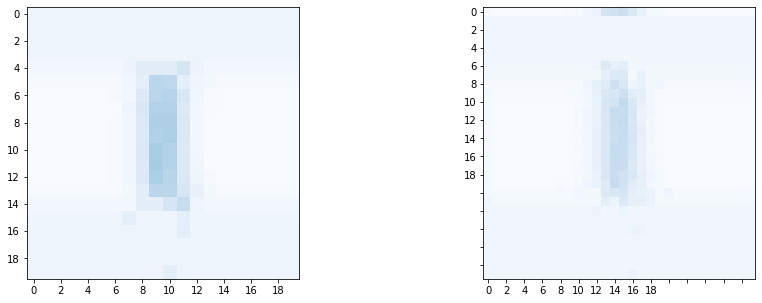

CPU times: user 15.1 s, sys: 463 ms, total: 15.5 s
Wall time: 14.6 s


In [39]:
%%time

i=0
for lc_our_detrend in our_detrends[:20]:   
    print ("recuperando curva",i+1)
    fluxs = prepare_lc(lc_our_detrend) #divide by min
    lc_tramos =  extract_nans(fluxs) #extract nans
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    per, t0 = df[["Period", "Time of Transit Epoch"]].values[index_con][i]
    mask_v = ~np.isnan(fluxs)
    f_glo = global_fold(time_kepler[index_con][i][mask_v], fluxs[mask_v], per, t0)
    axx[0].plot(fluxs)
    axx[0].set_title("Curva de luz")
    axx[1].plot(f_glo)
    axx[1].set_title("Curva en fase (folded)")
    plt.show()
    
    
    transition_m = manual_HMM(lc_tramos, n_sta_up=15, n_sta_low=15) #si se dejan 5 arriba y 10 abajo cambia harto...

    i+=1
    labels_x = [str(value) for value in np.arange(0,transition_m.shape[0],2)]
    
    f, axx = plt.subplots(1, 2,figsize= (15,5))
    axx[0].imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[0].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[0].set_xticklabels(labels_x)
    axx[0].set_yticklabels(labels_x)
    
    #curva en reversa...
    fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
    lc_tramos =  extract_nans(fluxs) #extract nans
    transition_m = manual_HMM(lc_tramos, n_sta_up=15, n_sta_low=15) #si se dejan 5 arriba y 10 abajo cambia harto...
    
    axx[1].imshow(transition_m, cmap='Blues', vmin=0, vmax=1) #el plot se ve raro por esto..
    axx[1].set_xticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_yticks(np.arange(0,transition_m.shape[0],2))
    axx[1].set_xticklabels(labels_x)
    axx[1].set_yticklabels(labels_x)
    plt.show()

### Normal (izq - der) NO BORRAR

In [9]:
ups=[8,16,32,64]
downs=[8,16,32,64]

In [12]:
for arriba in ups:
    for abajo in downs:
        matrices=[]
        print ("ARRIBA Y ABAJO", arriba,abajo)
        i=0
        for lc_our_detrend in our_process: 
            fluxs = prepare_lc(lc_our_detrend) #divide by min\n",
            lc_tramos =  extract_nans(fluxs, plot=False) #extract nans\n",
            transition_m = manual_HMM(lc_tramos, n_sta_up=arriba, n_sta_low=abajo) #si se dejan 5 arriba y 10 abajo cambia harto...\n",
            i+=1
            matrices.append(transition_m)

        matrices = np.asarray(matrices)

        folder2 = "/work/work_teamEXOPLANET/MTF_margarita/no_invertidos/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)
        print("Creada la configuracion")

ARRIBA Y ABAJO 16 16
Creada la configuracion
ARRIBA Y ABAJO 16 32
Creada la configuracion
ARRIBA Y ABAJO 16 64
Creada la configuracion
ARRIBA Y ABAJO 32 16
Creada la configuracion
ARRIBA Y ABAJO 32 32
Creada la configuracion
ARRIBA Y ABAJO 32 64
Creada la configuracion
ARRIBA Y ABAJO 64 16
Creada la configuracion
ARRIBA Y ABAJO 64 32
Creada la configuracion
ARRIBA Y ABAJO 64 64
Creada la configuracion


In [11]:
for arriba in ups:
    for abajo in downs:
        matrices=[]
        print ("ARRIBA Y ABAJO", arriba,abajo)
        i=0
        for lc_our_detrend in our_process: 
            fluxs = prepare_lc(lc_our_detrend[::-1]) #divide by min\n",
            lc_tramos =  extract_nans(fluxs, plot=False) #extract nans\n",
            transition_m = manual_HMM(lc_tramos, n_sta_up=arriba, n_sta_low=abajo) #si se dejan 5 arriba y 10 abajo cambia harto...\n",
            i+=1
            matrices.append(transition_m)

        matrices = np.asarray(matrices)

        folder2 = "/work/work_teamEXOPLANET/MTF_margarita/invertidos/"
        np.save(folder2+'MTF_u'+str(arriba)+"_d"+str(abajo)+".npy", matrices)
        print("Creada la configuracion")

ARRIBA Y ABAJO 16 16
Creada la configuracion
ARRIBA Y ABAJO 16 32
Creada la configuracion
ARRIBA Y ABAJO 16 64
Creada la configuracion
ARRIBA Y ABAJO 32 16
Creada la configuracion
ARRIBA Y ABAJO 32 32
Creada la configuracion
ARRIBA Y ABAJO 32 64
Creada la configuracion
ARRIBA Y ABAJO 64 16
Creada la configuracion
ARRIBA Y ABAJO 64 32
Creada la configuracion
ARRIBA Y ABAJO 64 64
Creada la configuracion
